In [106]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import dask
import pandas as pd
import glob
import datetime
from dateutil.relativedelta import relativedelta
from functools import partial

from SMYLEutils import calendar_utils as cal
from SMYLEutils import eof_utils as eof
from SMYLEutils import stat_utils as stat
import matplotlib.lines as mlines

import importlib
importlib.reload(eof)

dask.config.set(**{'array.slicing.split_large_chunks': True})

### set up the dask cluster

In [132]:
from dask_jobqueue import PBSCluster
from dask.distributed import Client

cluster = PBSCluster(
    cores = 1,
    memory = '10GB',
    processes = 1,
    queue = 'casper',
    local_directory='$TMPDIR',
    resource_spec='select=1:ncpus=1:mem=10GB',
    project='P04010022',
    walltime='02:00:00',
    interface='ib0')

# scale up
cluster.scale(20)

# change your urls to the dask dashboard so that you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

/glade/u/home/islas/miniconda3/envs/ecpaperenv/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37058 instead
  http_address["port"], self.http_server.port


In [135]:
client

Client Scheduler: tcp://10.12.206.54:41976 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/islas/proxy/37058/status,Cluster Workers: 20 Cores: 20 Memory: 200.00 GB


### Set up basic info

In [30]:
ystart=1970 # start year of hindcasts
yend = 2018 # end year of hindcasts
nyears=yend-ystart+1
initmon=[2,5,8,11] # initialization month
domain = "atm" ; freq="month_1" ; var="PSL"
nmems = 20 # the number of hindcast members
memstr = [str(i).zfill(3) for i in np.arange(1,nmems+1,1)] # generating member strings
topdir="/glade/campaign/cesm/development/espwg/SMYLE/archive/"
expname="b.e21.BSMYLE.f09_g17"

### Reading in SMYLE

In [31]:
%%time
# Set up nested filenames
febfiles = []
for iyear in np.arange(ystart, yend+1, 1):
    febfilest=[glob.glob(topdir+expname+"."+str(iyear)+"-02."+imem+"/"+domain+"/proc/tseries/"+freq+"/*."+var+".*")[0] for imem in memstr]
    febfiles.append(febfilest)
    
mayfiles = []
for iyear in np.arange(ystart, yend+1, 1):
    mayfilest=[glob.glob(topdir+expname+"."+str(iyear)+"-05."+imem+"/"+domain+"/proc/tseries/"+freq+"/*."+var+".*")[0] for imem in memstr]
    mayfiles.append(mayfilest)
    
augfiles = []
for iyear in np.arange(ystart, yend+1, 1):
    augfilest=[glob.glob(topdir+expname+"."+str(iyear)+"-08."+imem+"/"+domain+"/proc/tseries/"+freq+"/*."+var+".*")[0] for imem in memstr]
    augfiles.append(augfilest)
    
novfiles = []
for iyear in np.arange(ystart, yend+1, 1):
    novfilest=[glob.glob(topdir+expname+"."+str(iyear)+"-11."+imem+"/"+domain+"/proc/tseries/"+freq+"/*."+var+".*")[0] for imem in memstr]
    novfiles.append(novfilest)

CPU times: user 3.75 s, sys: 1.93 s, total: 5.68 s
Wall time: 1min 15s


In [32]:
# pre-processor to ensure all initialization dates have the same time axis
def preprocessor(ds):
    # sort out the times so that each member has the same time axis
    timebndavg = np.array(ds.time_bnds,
                         dtype = 'datetime64[s]').view('i8').mean(axis=1).astype('datetime64[s]')
    ds['time'] = timebndavg
    datestart = pd.to_datetime("1970-"+str(ds.isel(time=0).time.dt.month.values).zfill(2)+"-"+str(ds.isel(time=0).time.dt.day.values).zfill(2))
    time = [ datestart + relativedelta(months=i) for i in np.arange(0,24,1) ]
    ds['time'] = time
    return ds

In [33]:
# Function for selecting the North Atlantic domain
def getnatl(ds):
    datwest = ds.sel(lon=slice(360-90,359.9))
    dateast = ds.sel(lon=slice(0,40))
    datwest['lon'] = datwest.lon - 360.
    datout = xr.concat([datwest, dateast], dim='lon')
    datout = datout.sel(lat=slice(20,80))
    return datout

In [34]:
%%time
# read in the data
feb = xr.open_mfdataset(febfiles, combine='nested', concat_dim=['init_year','M'],
                        parallel=True, data_vars=[var], coords='minimal', compat='override', preprocess=partial(preprocessor))
feb_natl = getnatl(feb)
feb_natl_seas = cal.mon_to_seas(feb_natl.PSL).compute()

may = xr.open_mfdataset(mayfiles, combine='nested', concat_dim=['init_year','M'],
                        parallel=True, data_vars=[var], coords='minimal', compat='override', preprocess=partial(preprocessor))
may_natl = getnatl(may)
may_natl_seas = cal.mon_to_seas(may_natl.PSL).compute()

aug = xr.open_mfdataset(augfiles, combine='nested', concat_dim=['init_year','M'],
                        parallel=True, data_vars=[var], coords='minimal', compat='override', preprocess=partial(preprocessor))
aug_natl = getnatl(aug)
aug_natl_seas = cal.mon_to_seas(aug_natl.PSL).compute()

nov = xr.open_mfdataset(novfiles, combine='nested', concat_dim=['init_year','M'],
                        parallel=True, data_vars=[var], coords='minimal', compat='override', preprocess=partial(preprocessor))
nov_natl = getnatl(nov)
nov_natl_seas = cal.mon_to_seas(nov_natl.PSL).compute()

CPU times: user 8min 35s, sys: 42.9 s, total: 9min 18s
Wall time: 13min 19s


In [35]:
# Remove lead dependent climatologies
# Calculate seasonal means,  drop the incomplite seasons
# rename time axis to season
def sortoutarrays(dat):
    dat = dat - dat.mean(['M','init_year'])
    dat = dat.dropna(dim='time')
    dat = dat.rename({'time':'season'})
    dat = dat.dropna(dim='season').compute()
    return dat

feb_natl_seas = sortoutarrays(feb_natl_seas)
may_natl_seas = sortoutarrays(may_natl_seas)
aug_natl_seas = sortoutarrays(aug_natl_seas)
nov_natl_seas = sortoutarrays(nov_natl_seas)
    
feb_natl_seas = feb_natl_seas.rename('feb_natl_seas')
may_natl_seas = may_natl_seas.rename('may_natl_seas')
aug_natl_seas = aug_natl_seas.rename('aug_natl_seas')
nov_natl_seas = nov_natl_seas.rename('nov_natl_seas')

### Reading in the DPLE

In [141]:
dplefiles = []
topdirdple="/glade/campaign/cesm/collections/CESM1-DPLE/atm/proc/tseries/monthly/PSL/"
memstrdple = [str(i).zfill(3) for i in np.arange(1,40+1,1)]
for iyear in np.arange(ystart,yend,1):
    dplefilest=[glob.glob(topdirdple+'b.e11.BDP.f09_g16.'+str(iyear)+'-11.'+imem+'.*.nc')[0] for imem in memstrdple]
    dplefiles.append(dplefilest)

In [142]:
# pre-processor to ensure all initialization dates have the same time axis
def preprocessor(ds):
    # sort out the times so that each member has the same time axis
    timebndavg = np.array(ds.time_bnds,
                         dtype = 'datetime64[s]').view('i8').mean(axis=1).astype('datetime64[s]')
    ds['time'] = timebndavg
    ds = ds.isel(time=slice(0,24))
    datestart = pd.to_datetime("1970-"+str(ds.isel(time=0).time.dt.month.values).zfill(2)+"-"+str(ds.isel(time=0).time.dt.day.values).zfill(2))
    time = [ datestart + relativedelta(months=i) for i in np.arange(0,24,1) ]
    ds['time'] = time
    return ds

In [143]:
novdple = xr.open_mfdataset(dplefiles, combine='nested', concat_dim=['init_year','M'],
                        parallel=True, data_vars=[var], coords='minimal', compat='override', preprocess=partial(preprocessor))

In [151]:
novdple_natl = getnatl(novdple)
novdple_natl_seas = cal.mon_to_seas(novdple_natl.PSL).compute()

In [152]:
novdple_natl_seas = sortoutarrays(novdple_natl_seas)
novdple_natl_seas = novdple_natl_seas.rename('novdple_natl_seas')

### Reading in ERA5

In [36]:
era5file="/glade/campaign/cesm/development/espwg/verification_datasets/mon/SLP/SLP_ERA5_oncamgrid_1950_2020.nc"
era5 = xr.open_dataset(era5file)
era5 = era5.slp

feb_era5 = xr.DataArray(np.zeros([feb.init_year.size, feb.time.size, era5.lat.size, era5.lon.size]),
                        dims=['init_year','time','lat','lon'],
                        coords=[feb.init_year, feb.time, feb.lat, feb.lon], name='feb_era5')
may_era5 = xr.DataArray(np.zeros([may.init_year.size, may.time.size, era5.lat.size, era5.lon.size]),
                        dims=['init_year','time','lat','lon'],
                        coords=[may.init_year, may.time, may.lat, may.lon], name='may_era5')
aug_era5 = xr.DataArray(np.zeros([aug.init_year.size, aug.time.size, era5.lat.size, era5.lon.size]),
                        dims=['init_year','time','lat','lon'],
                        coords=[aug.init_year, aug.time, aug.lat, aug.lon], name='aug_era5')
nov_era5 = xr.DataArray(np.zeros([nov.init_year.size, nov.time.size, era5.lat.size, era5.lon.size]),
                        dims=['init_year','time','lat','lon'],
                        coords=[nov.init_year, nov.time, nov.lat, nov.lon], name='nov_era5')

for iyear in np.arange(ystart,yend+1,1):
    feb_era5[iyear-ystart,:,:,:] = np.array(era5.sel(time=slice(str(iyear)+"-02",str(iyear+2)+"-01")))
    may_era5[iyear-ystart,:,:,:] = np.array(era5.sel(time=slice(str(iyear)+"-05",str(iyear+2)+"-04")))
    aug_era5[iyear-ystart,:,:,:] = np.array(era5.sel(time=slice(str(iyear)+"-08",str(iyear+2)+"-07")))
    nov_era5[iyear-ystart,:,:,:] = np.array(era5.sel(time=slice(str(iyear)+"-11",str(iyear+2)+"-10")))

feb_era5_seas = cal.mon_to_seas(feb_era5).dropna(dim='time')
may_era5_seas = cal.mon_to_seas(may_era5).dropna(dim='time')
aug_era5_seas = cal.mon_to_seas(aug_era5).dropna(dim='time')
nov_era5_seas = cal.mon_to_seas(nov_era5).dropna(dim='time')

feb_era5_seas = feb_era5_seas.rename({'time':'season'})
may_era5_seas = may_era5_seas.rename({'time':'season'})
aug_era5_seas = aug_era5_seas.rename({'time':'season'})
nov_era5_seas = nov_era5_seas.rename({'time':'season'})

feb_era5_natl_seas = getnatl(feb_era5_seas)
may_era5_natl_seas = getnatl(may_era5_seas)
aug_era5_natl_seas = getnatl(aug_era5_seas)
nov_era5_natl_seas = getnatl(nov_era5_seas)

feb_era5_natl_seas = feb_era5_natl_seas - feb_era5_natl_seas.mean('init_year')
may_era5_natl_seas = may_era5_natl_seas - may_era5_natl_seas.mean('init_year')
aug_era5_natl_seas = aug_era5_natl_seas - aug_era5_natl_seas.mean('init_year')
nov_era5_natl_seas = nov_era5_natl_seas - nov_era5_natl_seas.mean('init_year')

### Starting the calculations

Station based NAO

In [155]:
# set up longitudes and latitudes for the station based NAO
reyklon = -21.9426 ; reyklat = 64.1466
azorelon = -25.6687 ; azorelat = 25.6687

nao_st_feb_smyle = feb_natl_seas.sel(lon=azorelon, lat=azorelat, method="nearest") - feb_natl_seas.sel(lon=reyklon, lat=reyklat, method="nearest")
nao_st_may_smyle = may_natl_seas.sel(lon=azorelon, lat=azorelat, method="nearest") - may_natl_seas.sel(lon=reyklon, lat=reyklat, method="nearest")
nao_st_aug_smyle = aug_natl_seas.sel(lon=azorelon, lat=azorelat, method="nearest") - aug_natl_seas.sel(lon=reyklon, lat=reyklat, method="nearest")
nao_st_nov_smyle = nov_natl_seas.sel(lon=azorelon, lat=azorelat, method="nearest") - nov_natl_seas.sel(lon=reyklon, lat=reyklat, method="nearest")

nao_st_feb_era5 = feb_era5_natl_seas.sel(lon=azorelon, lat=azorelat, method='nearest') - feb_era5_natl_seas.sel(lon=reyklon, lat=reyklat, method='nearest')
nao_st_may_era5 = may_era5_natl_seas.sel(lon=azorelon, lat=azorelat, method='nearest') - may_era5_natl_seas.sel(lon=reyklon, lat=reyklat, method='nearest')
nao_st_aug_era5 = aug_era5_natl_seas.sel(lon=azorelon, lat=azorelat, method='nearest') - aug_era5_natl_seas.sel(lon=reyklon, lat=reyklat, method='nearest')
nao_st_nov_era5 = nov_era5_natl_seas.sel(lon=azorelon, lat=azorelat, method='nearest') - nov_era5_natl_seas.sel(lon=reyklon, lat=reyklat, method='nearest')

nao_st_nov_dple = novdple_natl_seas.sel(lon=azorelon, lat=azorelat, method='nearest') - novdple_natl_seas.sel(lon=reyklon, lat=reyklat, method='nearest')

EOF based NAO

In [156]:
#SMYLE
def calcNAO(dat,lonneg, latneg):
    dat = dat.stack(z=['M','init_year'])
    pc = xr.DataArray(np.zeros([dat.z.size, dat.season.size]), dims=['z','season'],
                      coords=[dat.z, dat.season],name='pc')
    pattern = xr.DataArray(np.zeros([dat.season.size, dat.lat.size, dat.lon.size]),
                           dims=['season','lat','lon'], 
                           coords=[dat.season, dat.lat, dat.lon], name='pattern')
    for iseas in np.arange(0, dat.season.size,1):
        pct, eoft = eof.eofcalc_pcnorm(dat.isel(season=iseas), neofs=1, timeaxis='z', lonneg=lonneg, latneg=latneg)
        pc[:,iseas] = pct[:,0]
        pattern[iseas,:,:] = eoft[0,:,:]
    pc = pc.unstack(dim='z')
    return pc, pattern

pc_feb, pattern_feb = calcNAO(feb_natl_seas, -20, 75)
pc_may, pattern_may = calcNAO(may_natl_seas, -20, 75)
pc_aug, pattern_aug = calcNAO(aug_natl_seas, -20, 75)
pc_nov, pattern_nov = calcNAO(nov_natl_seas, -20, 75)

pc_nov_dple, pattern_nov_dple = calcNAO(novdple_natl_seas, -20, 75)

In [40]:
#ERA5
def calcNAO(dat, lonneg, latneg):
    pc = xr.DataArray(np.zeros([dat.init_year.size, dat.season.size]), dims=['init_year','season'],
                      coords=[dat.init_year, dat.season],name='pc')
    pattern = xr.DataArray(np.zeros([dat.season.size, dat.lat.size, dat.lon.size]),
                           dims=['season','lat','lon'], 
                           coords=[dat.season, dat.lat, dat.lon], name='pattern')
    for iseas in np.arange(0, dat.season.size,1):
        pct, eoft = eof.eofcalc_pcnorm(dat.isel(season=iseas), neofs=1, timeaxis='init_year', lonneg=lonneg, latneg=latneg)
        pc[:,iseas] = pct[:,0]
        pattern[iseas,:,:] = eoft[0,:,:]
    return pc, pattern

pc_feb_era5, pattern_feb_era5 = calcNAO(feb_era5_natl_seas, -20, 75)
pc_may_era5, pattern_may_era5 = calcNAO(may_era5_natl_seas, -20, 75)
pc_aug_era5, pattern_aug_era5 = calcNAO(aug_era5_natl_seas, -20, 75)
pc_nov_era5, pattern_nov_era5 = calcNAO(nov_era5_natl_seas, -20, 75)

In [159]:
print(nao_st_nov_era5)

<xarray.DataArray (init_year: 49, season: 7)>
array([[-5.65500063e+02, -2.28946451e+01, -2.09005034e+02,
        -2.91371516e+02,  1.62713949e+02,  3.85758759e+02,
         4.06701608e+02],
       [ 2.01599811e+02,  3.86124034e+02,  4.09015824e+02,
        -2.60455949e+02,  6.58734362e+02, -4.13518139e+02,
         2.49498210e+02],
       [ 7.01483902e+02, -4.13152864e+02,  2.51812427e+02,
        -5.71563285e+02,  6.06879953e+02,  2.09988375e+00,
         1.33068305e+02],
       [ 6.49399518e+02,  2.46515825e+00,  1.35382521e+02,
         1.29784349e+01,  4.46107832e+02, -4.97549123e+02,
        -3.85853001e+01],
       [ 4.92660967e+02, -4.97183849e+02, -3.62710833e+01,
         1.54053019e+02, -3.16592029e+02,  6.16722357e+02,
         7.92099895e+01],
       [-2.88246649e+02,  6.17087632e+02,  8.15242062e+01,
         2.81568505e+01, -1.07110869e+03, -2.83314101e+02,
        -2.22907130e+02],
       [-1.03949397e+03, -2.82948826e+02, -2.20592913e+02,
         1.97153421e+02, -4.955

In [158]:
print(nao_st_nov_dple)

<xarray.DataArray 'novdple_natl_seas' (M: 40, init_year: 48, season: 7)>
array([[[ 1.97057400e+02,  1.39602925e+02,  7.22116183e+01, ...,
         -7.28268032e+01, -1.44744100e+02, -3.68942284e+02],
        [ 6.61081966e+02,  3.56678502e+02,  6.14128483e+02, ...,
          5.88273863e+01,  8.55633895e+01, -1.72701370e+02],
        [ 6.33022070e+02,  4.09082035e+02,  2.12602328e+02, ...,
          9.71628087e+01, -3.35193829e+02,  2.89073766e+02],
        ...,
        [-8.04513607e+02,  1.70995673e+02,  6.07174776e+01, ...,
          6.52986899e+02,  7.18116464e+02,  1.00826825e+01],
        [-4.80152843e+02, -2.25465944e+02, -3.66127037e+02, ...,
          6.89090951e+02,  5.94278063e+02,  2.35088372e+02],
        [-7.94654579e+02,  3.74760533e+02,  1.13374747e+02, ...,
          1.58251150e+02, -1.52133876e+02,  5.38396711e+02]],

       [[ 8.16859483e+02, -7.15756588e+01,  3.58962807e+02, ...,
          5.96905855e+02,  2.50924718e+02,  4.32206239e+02],
        [ 7.48817990e+02,  3.7

### Correlation coefficients

In [161]:
cor_feb_st = xr.corr(nao_st_feb_smyle.mean('M'), nao_st_feb_era5, dim='init_year')
cor_may_st = xr.corr(nao_st_may_smyle.mean('M'), nao_st_may_era5, dim='init_year')
cor_aug_st = xr.corr(nao_st_aug_smyle.mean('M'), nao_st_aug_era5, dim='init_year')
cor_nov_st = xr.corr(nao_st_nov_smyle.mean('M'), nao_st_nov_era5, dim='init_year')
cor_novdple_st = xr.corr(nao_st_nov_dple.mean('M'), nao_st_nov_era5.isel(init_year=slice(0,48)), dim='init_year')

cor_feb_eof = xr.corr(pc_feb.mean('M'), pc_feb_era5, dim='init_year')
cor_may_eof = xr.corr(pc_may.mean('M'), pc_may_era5, dim='init_year')
cor_aug_eof = xr.corr(pc_aug.mean('M'), pc_aug_era5, dim='init_year')
cor_nov_eof = xr.corr(pc_nov.mean('M'), pc_nov_era5, dim='init_year')
cor_novdple_eof = xr.corr(pc_nov_dple.mean('M'), pc_nov_era5.isel(init_year=slice(0,48)), dim='init_year')


### Confidence intervals on correlation coefficients

In [163]:
# Note - may want to update this to include bootstrapping on ensemble members as well as initialization years
ci_feb_st = np.zeros([cor_feb_st.season.size,2]) 
ci_feb_eof = np.zeros([cor_feb_eof.season.size,2])
signif_feb_st = np.zeros([cor_feb_st.season.size])
signif_feb_eof = np.zeros([cor_feb_eof.season.size])
for iseas in np.arange(0,cor_feb_st.season.size,1):
    min95, max95 = stat.cor_ci_bootyears(nao_st_feb_smyle.isel(season=iseas).mean('M'), nao_st_feb_era5.isel(season=iseas))
    ci_feb_st[iseas,0] = min95 ; ci_feb_st[iseas,1] = max95
    if ((min95 > 0) | (max95 < 0)):
        signif_feb_st[iseas]=1
    
    min95, max95 = stat.cor_ci_bootyears(pc_feb.isel(season=iseas).mean('M'), pc_feb_era5.isel(season=iseas))
    ci_feb_eof[iseas,0] = min95 ; ci_feb_eof[iseas,1] = max95
    if ((min95 > 0) | (max95 < 0)):
        signif_feb_eof[iseas]=1
    
ci_may_st = np.zeros([cor_may_st.season.size,2]) 
ci_may_eof = np.zeros([cor_may_eof.season.size,2]) 
signif_may_st = np.zeros([cor_may_st.season.size])
signif_may_eof = np.zeros([cor_may_eof.season.size])
for iseas in np.arange(0,cor_may_st.season.size,1):
    min95, max95 = stat.cor_ci_bootyears(nao_st_may_smyle.isel(season=iseas).mean('M'), nao_st_may_era5.isel(season=iseas))
    ci_may_st[iseas,0] = min95 ; ci_may_st[iseas,1] = max95
    if ((min95 > 0) | (max95 < 0)):
        signif_may_st[iseas]=1
        
    min95, max95 = stat.cor_ci_bootyears(pc_may.isel(season=iseas).mean('M'), pc_may_era5.isel(season=iseas))
    ci_may_eof[iseas,0] = min95 ; ci_may_eof[iseas,1] = max95
    if ((min95 > 0) | (max95 < 0)):
        signif_may_eof[iseas]=1
        
ci_aug_st = np.zeros([cor_aug_st.season.size,2])
ci_aug_eof = np.zeros([cor_aug_eof.season.size,2])
signif_aug_st = np.zeros([cor_aug_st.season.size])
signif_aug_eof = np.zeros([cor_aug_eof.season.size])
for iseas in np.arange(0,cor_aug_st.season.size,1):
    min95, max95 = stat.cor_ci_bootyears(nao_st_aug_smyle.isel(season=iseas).mean('M'), nao_st_aug_era5.isel(season=iseas))
    ci_aug_st[iseas,0] = min95 ; ci_aug_st[iseas,1] = max95
    if ((min95 > 0) | (max95 < 0)):
        signif_aug_st[iseas]=1
        
    min95, max95 = stat.cor_ci_bootyears(pc_aug.isel(season=iseas).mean('M'), pc_aug_era5.isel(season=iseas))
    ci_aug_eof[iseas,0] = min95 ; ci_aug_eof[iseas,1] = max95
    if ((min95 > 0) | (max95 < 0)):
        signif_aug_eof[iseas]=1
    
ci_nov_st = np.zeros([cor_nov_st.season.size,2]) 
ci_nov_eof = np.zeros([cor_nov_eof.season.size,2])

ci_nov_st_dple = np.zeros([cor_novdple_st.season.size,2]) 
ci_nov_eof_dple = np.zeros([cor_novdple_eof.season.size,2])

signif_nov_st = np.zeros([cor_nov_st.season.size])
signif_nov_eof = np.zeros([cor_nov_eof.season.size])

signif_nov_st_dple = np.zeros([cor_nov_st.season.size])
signif_nov_eof_dple = np.zeros([cor_nov_eof.season.size])
for iseas in np.arange(0,cor_nov_st.season.size,1):
    min95, max95 = stat.cor_ci_bootyears(nao_st_nov_smyle.isel(season=iseas).mean('M'), nao_st_nov_era5.isel(season=iseas))
    ci_nov_st[iseas,0] = min95 ; ci_nov_st[iseas,1] = max95
    if ((min95 > 0) | (max95 < 0)):
        signif_nov_st[iseas]=1
        
    min95, max95 = stat.cor_ci_bootyears(pc_nov.isel(season=iseas).mean('M'), pc_nov_era5.isel(season=iseas))
    ci_nov_eof[iseas,0] = min95 ; ci_nov_eof[iseas,1] = max95
    if ((min95 > 0) | (max95 < 0)):
        signif_nov_eof[iseas]=1
        
    min95, max95 = stat.cor_ci_bootyears(nao_st_nov_dple.isel(season=iseas).mean('M'), nao_st_nov_era5.isel(init_year=slice(0,48),season=iseas))
    ci_nov_st_dple[iseas,0] = min95 ; ci_nov_st_dple[iseas,1] = max95
    if ((min95 > 0) | (max95 < 0)):
        signif_nov_st_dple[iseas]=1
        
    min95, max95 = stat.cor_ci_bootyears(pc_nov_dple.isel(season=iseas).mean('M'), pc_nov_era5.isel(init_year=slice(0,48), season=iseas))
    ci_nov_eof_dple[iseas,0] = min95 ; ci_nov_eof_dple[iseas,1] = max95
    if ((min95 > 0) | (max95 < 0)):
        signif_nov_eof_dple[iseas]=1

In [167]:
def setupnaopanel(title, x1, x2, y1, y2):
    ax = fig.add_axes([x1, y1, x2-x1, y2-y1])
    ax.set_ylim(-0.4,1)
    ax.set_xticks([1,4,7,10,13,16,19])
    ax.set_xticklabels(['1','4','7','10','13','16','19'], fontsize=14)
    ax.set_yticks([-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
    ax.set_yticklabels(['-0.4','-0.2','0','0.2','0.4','0.6','0.8','1'], fontsize=14)
    ax.grid(True)
    ax.set_xlabel('Lead Month', fontsize=14)
    ax.set_ylabel('ACC', fontsize=14)
    ax.set_title(title, fontsize=16)
    return ax

def plotinit(ax, corvals, signif, color, labelinit='', linestyle='solid'):
    markers={1:'D',4:'o',7:'s',10:'P'}
    ax.plot(np.arange(0,corvals.season.size,1)*3 + 1, corvals, color=color, label=labelinit, linestyle=linestyle)
    for i in range(0,corvals.season.size,1):
        if (signif[i] == 0):
            ax.plot(i*3 + 1, corvals.isel(season=i), markers[np.int(corvals.season.isel(season=i).dt.month.values)], color=color,
                    markersize=11, fillstyle='none')
        else:
            ax.plot(i*3 + 1, corvals.isel(season=i), markers[np.int(corvals.season.isel(season=i).dt.month.values)], color=color,
                    markersize=11)
    return ax

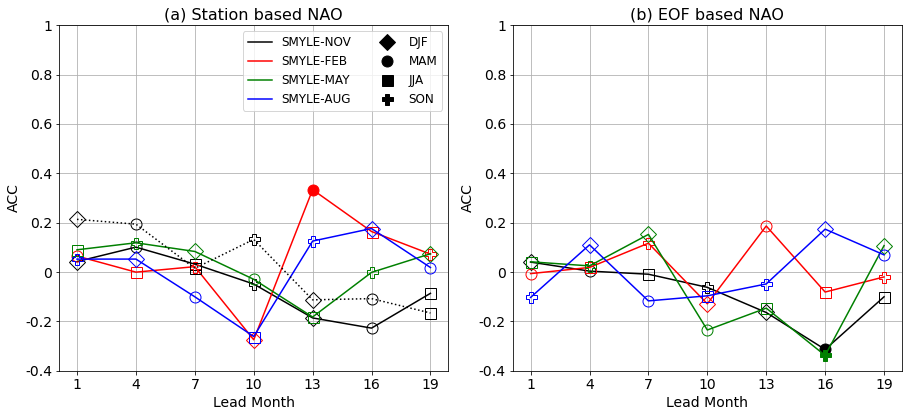

In [168]:
fig = plt.figure(figsize=(18,12))

markers={1:'D',4:'o',7:'s',10:'P'}

ax = setupnaopanel('(a) Station based NAO', 0.1,0.4,0.6,1)
ax = plotinit(ax, cor_nov_st, signif_nov_st, 'k', labelinit='SMYLE-NOV')
ax = plotinit(ax, cor_feb_st, signif_feb_st, 'r', labelinit='SMYLE-FEB')
ax = plotinit(ax, cor_may_st, signif_may_st, 'g', labelinit='SMYLE-MAY')
ax = plotinit(ax, cor_aug_st, signif_aug_st, 'b', labelinit='SMYLE-AUG')
#ax = plotinit(ax, cor_novdple_st, signif_nov_st_dple,'k', labelinit='DPLE-NOV', linestyle='dotted')
nov = mlines.Line2D([],[], color='k', label='SMYLE-NOV')
feb = mlines.Line2D([],[], color='r', label='SMYLE-FEB')
may = mlines.Line2D([],[], color='g', label='SMYLE-MAY')
aug = mlines.Line2D([],[], color='b', label='SMYLE-AUG')

djf = mlines.Line2D([],[],color='k', marker=markers[1], markersize=11, label='DJF', linestyle='None')
mam = mlines.Line2D([],[],color='k', marker=markers[4], markersize=11, label='MAM', linestyle='None')
jja = mlines.Line2D([],[],color='k', marker=markers[7], markersize=11, label='JJA', linestyle='None')
son = mlines.Line2D([],[],color='k', marker=markers[10], markersize=11, label='SON', linestyle='None')

ax.legend(handles=[nov, feb, may, aug,djf, mam, jja, son], ncol=2, fontsize=12)
#ax.legend()

ax = setupnaopanel('(b) EOF based NAO', 0.45,0.75,0.6,1)
ax = plotinit(ax, cor_nov_eof, signif_nov_eof, 'k')
ax = plotinit(ax, cor_feb_eof, signif_feb_eof, 'r')
ax = plotinit(ax, cor_may_eof, signif_may_eof, 'g')
ax = plotinit(ax, cor_aug_eof, signif_aug_eof, 'b')
   
fig.savefig(plotpath+'
    

In [383]:
def makeskillplot(corst, coreof, cist, cieof, title,x1, x2, y1, y2, ylim=None):
    ax = fig.add_axes([x1, y1, x2-x1, y2-y1])
    ax.set_title(title, fontsize=14)
    ax.plot([0.5,7.5],[0,0], color='black')
    ax.set_xlim([0.5,7.5])
    ax.set_xticks(np.arange(0,corst.season.size,1)+1)
    ax.set_xticklabels(corst.season.dt.season.values, fontsize=12)
    ax.set_ylabel('Correlation', fontsize=12)
    
    if (ylim):
        ax.set_ylim(ylim)
    
    for iseas in np.arange(0,corst.season.size,1):
        if (iseas == 0):
            ax.bar(iseas+1-0.1, corst.isel(season=iseas), width=0.2, bottom=0, align='center', color='red', 
                   edgecolor='black', linewidth=2, label='Station based')
        else:
            ax.bar(iseas+1-0.1, corst.isel(season=iseas), width=0.2, bottom=0, align='center', color='red', 
                   edgecolor='black', linewidth=2)
        ax.errorbar(iseas+1-0.1, corst.isel(season=iseas), [[corst.isel(season=iseas) - cist[iseas,0]],
                                                                [cist[iseas,1]-corst.isel(season=iseas)]],
                                                                color='black', linewidth=2, capsize=5, capthick=2)
        
        if (iseas == 0):
            ax.bar(iseas+1+0.1, coreof.isel(season=iseas), width=0.2, bottom=0, align='center', color='royalblue', 
                   edgecolor='black', linewidth=2, label='EOF based')
        else:
            ax.bar(iseas+1+0.1, coreof.isel(season=iseas), width=0.2, bottom=0, align='center', color='royalblue', 
                   edgecolor='black', linewidth=2)
        ax.errorbar(iseas+1+0.1, coreof.isel(season=iseas), [[coreof.isel(season=iseas) - cieof[iseas,0]],
                                                                [cieof[iseas,1]-coreof.isel(season=iseas)]],
                                                                color='black', linewidth=2, capsize=5, capthick=2)
        
    return ax   

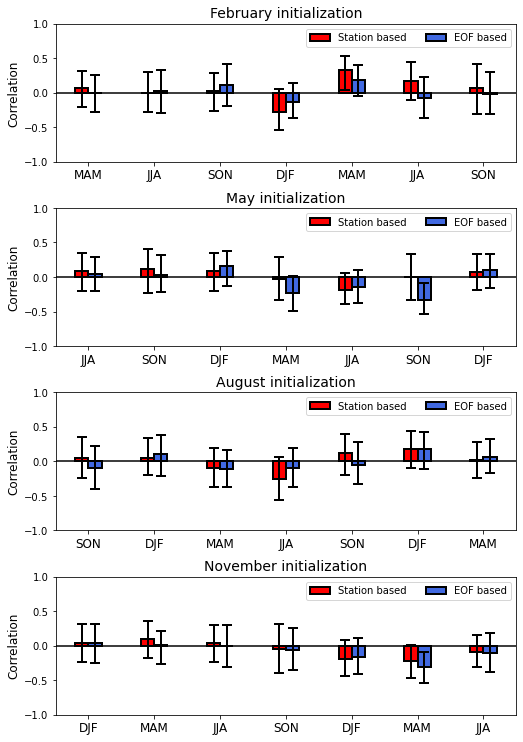

In [423]:
fig = plt.figure(figsize=(16,16))

ax = makeskillplot(cor_feb_st, cor_feb_eof, ci_feb_st, ci_feb_eof, 'February initialization',0.05,0.45,0.85,0.97, ylim=(-1,1))
ax.legend(ncol=2)

ax = makeskillplot(cor_may_st, cor_may_eof, ci_may_st, ci_may_eof, 'May initialization',0.05,0.45,0.69,0.81, ylim=(-1,1))
ax.legend(ncol=2)

ax = makeskillplot(cor_aug_st, cor_aug_eof, ci_aug_st, ci_aug_eof, 'August initialization',0.05,0.45,0.53,0.65, ylim=(-1,1))
ax.legend(ncol=2)

ax = makeskillplot(cor_nov_st, cor_nov_eof, ci_nov_st, ci_nov_eof, 'November initialization',0.05,0.45,0.37, 0.49, ylim=(-1,1))
ax.legend(ncol=2)

fig.savefig('naoskill.png', bbox_inches='tight', facecolor='white')

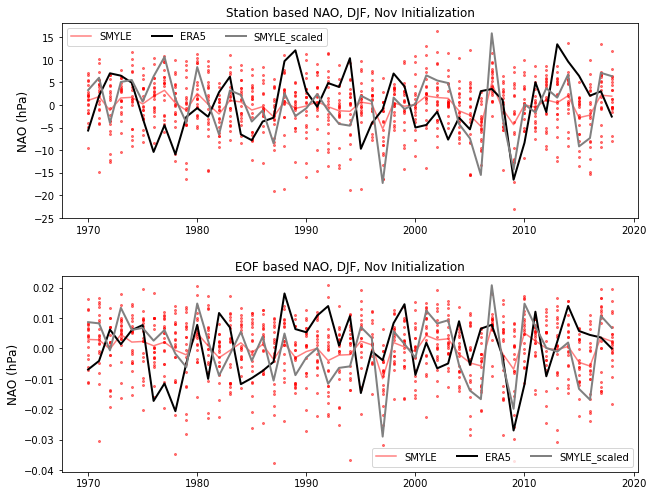

In [422]:
fig = plt.figure(figsize=(16,16))

#-----------------Station based NAO
ax = fig.add_axes([0.05,0.8,0.5,0.17])
ax.set_ylabel('NAO (hPa)', fontsize=12)
ax.set_title('Station based NAO, DJF, Nov Initialization', fontsize=12)

ax.plot(np.arange(ystart,yend+1,1), nao_st_nov_smyle.isel(season=0).mean('M')/100., color='red', alpha=0.5, 
       label='SMYLE')
for iyear in np.arange(0,yend-ystart+1,1):
    ax.plot(np.arange(0,nao_st_nov_smyle.M.size,1)*0 + ystart+iyear, nao_st_nov_smyle.isel(init_year=iyear, season=0)/100.,"o", color='red', 
           markersize=2, alpha=0.5)
ax.plot(np.arange(ystart,yend+1,1), nao_st_nov_era5.isel(season=0)/100., color='black', linewidth=2, label='ERA5')
era5stdev = nao_st_nov_era5.isel(season=0).std('init_year')
modelstdev = nao_st_nov_smyle.isel(season=0).mean('M').std('init_year')
ax.plot(np.arange(ystart,yend+1,1), (nao_st_nov_smyle.isel(season=0).mean('M')/100.)*era5stdev/modelstdev, color='gray', linewidth=2, 
                          label='SMYLE_scaled')
ax.legend(ncol=3)
#-------------------------------------

#-----------------EOF based NAO
ax = fig.add_axes([0.05,0.58,0.5,0.17])
ax.set_ylabel('NAO (hPa)', fontsize=12)
ax.set_title('EOF based NAO, DJF, Nov Initialization', fontsize=12)
ax.plot(np.arange(ystart,yend+1,1), pc_nov.isel(season=0).mean('M')/100., color='red', alpha=0.5, 
       label='SMYLE')
for iyear in np.arange(0,yend-ystart+1,1):
    ax.plot(np.arange(0,pc_nov.M.size,1)*0 + ystart+iyear, pc_nov.isel(init_year=iyear, season=0)/100.,"o", color='red', 
           markersize=2, alpha=0.5)
ax.plot(np.arange(ystart,yend+1,1), pc_nov_era5.isel(season=0)/100., color='black', linewidth=2, label='ERA5')
era5stdev = pc_nov_era5.isel(season=0).std('init_year')
modelstdev = pc_nov.isel(season=0).mean('M').std('init_year')
ax.plot(np.arange(ystart,yend+1,1), (pc_nov.isel(season=0).mean('M')/100.)*era5stdev/modelstdev, color='gray', linewidth=2, 
                          label='SMYLE_scaled')
ax.legend(ncol=3)
#-------------------------------------


fig.savefig('NAO_DJF_y1_timeseries.png', bbox_inches='tight', facecolor='white')